# IMDB Movies Review.
### Topic modeling & Sentiment Analysis

In [1]:
!pip install wordcloud

In [2]:
import sqlite3                                  #SQLite3 is a very easy to use database engine
import numpy as np
import pandas as pd
import wordcloud                                #wordcloud is a data visualization technique used for representing text data
import matplotlib.pyplot as plt

In [3]:
conn = sqlite3.connect("IMDB_Movies_2021.db")
query = 'SELECT AUTHOR,TITLE,REVIEW,RATING FROM REVIEWS'

In [4]:
df = pd.read_sql_query(query,conn)
df.head()

,AUTHOR,TITLE,REVIEW,RATING
0,margarida-44311,Not Bad\n,I don't get all the terrible reviews for this ...,5.0
1,joemay-2,What are all the bad reviews about is it a wo...,I cannot believe anyone could give this film l...,8.0
2,nebk,Great White=Jaws Lite\n,Great White is not the worst way to spend 90 m...,4.0
3,kuarinofu,Bare-bones killer shark film\n,Great White is as basic of a killer shark film...,4.0
4,Horror_Flick_Fanatic,"Terrible story, dialogue, and CGI\n","Terrible story, dialogue and CGI. The film has...",4.0


In [5]:
# Removing unnecessary newline characters
df = df.replace('\n','', regex=True)

# Visualizing 10 samples
df.head(10)

,AUTHOR,TITLE,REVIEW,RATING
0,margarida-44311,Not Bad,I don't get all the terrible reviews for this ...,5.0
1,joemay-2,What are all the bad reviews about is it a wo...,I cannot believe anyone could give this film l...,8.0
2,nebk,Great White=Jaws Lite,Great White is not the worst way to spend 90 m...,4.0
3,kuarinofu,Bare-bones killer shark film,Great White is as basic of a killer shark film...,4.0
4,Horror_Flick_Fanatic,"Terrible story, dialogue, and CGI","Terrible story, dialogue and CGI. The film has...",4.0
5,NickyDee07938,A decent effort,Whilst the 'shark survival' sub genre has plen...,6.0
6,Novelwolf,Nice Shark movie!,Much better than the ratings suggest. Its on p...,9.0
7,mbnn,"Nice, but could be so much better","First of all I love the film locations, drone ...",5.0
8,phobicsq,Typical movie for the genre,The film is meh when it comes to these types o...,4.0
9,rotini-52586,Liked it !,Thought it was a great Shark Movie . Special e...,7.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5450 entries, 0 to 5449
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AUTHOR  5450 non-null   object 
 1   TITLE   5450 non-null   object 
 2   REVIEW  5450 non-null   object 
 3   RATING  5332 non-null   float64
dtypes: float64(1), object(3)
memory usage: 170.4+ KB


In [7]:
df.isnull().sum()

AUTHOR      0
TITLE       0
REVIEW      0
RATING    118
dtype: int64

In [8]:
# drop missing values from RATING
df.dropna(subset=['RATING'], inplace = True)
df.reset_index(inplace=True, drop=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5332 entries, 0 to 5331
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AUTHOR  5332 non-null   object 
 1   TITLE   5332 non-null   object 
 2   REVIEW  5332 non-null   object 
 3   RATING  5332 non-null   float64
dtypes: float64(1), object(3)
memory usage: 166.8+ KB


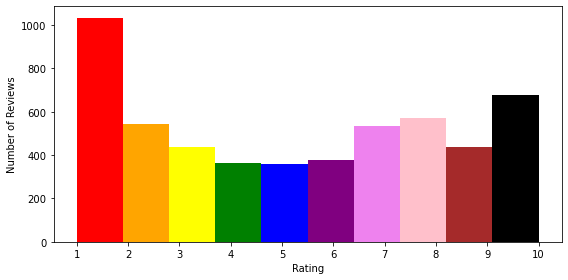

In [10]:
from matplotlib import colors

# Creating histogram
fig, axs = plt.subplots(1, 1,figsize =(8, 4), tight_layout = True)
axs.xaxis.set_ticks(range(0,11))  

N, bins, patches = axs.hist(df['RATING'])
  
colors_ = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'violet', 'pink', 'brown', 'black']

for colnum, thispatch in enumerate(patches):
    thispatch.set_facecolor(colors_[colnum])  
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()

In [11]:
# use the first 4000 rows as training data
data = df.loc[:3999, 'REVIEW'].tolist()

In [12]:
len(data)

4000

## Part 1: Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library. Stop words are words like "a", "the", or "in" which don't convey significant meaning. Stemming is the process of breaking a word down into its root

In [13]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("'s")
stopwords.append("'m")
stopwords.append("n't")
stopwords.append("br")

# this is a movie review dataset, so the word "movie" or "film "really doesn't give much sight
stopwords.append("movie")
stopwords.append("film")

print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords[:11])

We use 185 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've"]


User defined functions to analyze (i.e. tokenize, stem) our reviews.

In [15]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

# tokenization and stemming
def tokenization_and_stemming(text):
    tokens = []
    # exclude stop words and tokenize the document, generate a list of string 
    for word in nltk.word_tokenize(text):
        if word.lower() not in stopwords:
            tokens.append(word.lower())

    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if token.isalpha():
            filtered_tokens.append(token)
    
    #exclude stopwords from stemmed words
    stems = [stemmer.stem(t) for t in filtered_tokens if word not in stopwords]
    return stems

In [16]:
# test our function on data[0]

tokenization_and_stemming(data[0])

['get',
 'terribl',
 'review',
 'especi',
 'lot',
 'peopl',
 'talk',
 'incred',
 'bad',
 'special',
 'effect',
 'oscar',
 'worthi',
 'terribl',
 'quit',
 'good',
 'type',
 'lack',
 'qualiti',
 'script',
 'shark',
 'littl',
 'mistak',
 'overal',
 'watchabl',
 'fan',
 'genr',
 'recommend',
 'check',
 'score',
 'unfair',
 'work',
 'project']

In [17]:
data[0]

"I don't get all the terrible reviews for this movie. Especially because lots of people talk incredible bad of the special effects. It's not Oscar worthy, but is not terrible. It's quite good for such type of movie.It lacks some quality on the script, but which shark movie doesn't?There's some other little mistakes, but overall is watchable. If you are a fan of this genre, o recommend you check it out this one.Ignore the below 4 scores. It's unfair for those who work in this project."

## Part 2: TF-IDF

tf-idf is a feature extraction technique

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
# define vectorizer parameters
# TfidfVectorizer will help us to create tf-idf matrix
# max_df : maximum document frequency for the given word
# min_df : minimum document frequency for the given word
# max_features: maximum number of words
# use_idf: if not true, we only calculate tf
# stop_words : built-in stop words
# tokenizer: how to tokenize the document
# ngram_range: (min_value, max_value), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram
tfidf_model = TfidfVectorizer(max_df=0.99, max_features=1000,
                                 min_df=0.01, use_idf=True, stop_words = stopwords,
                              tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(data) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " reviews and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 4000 reviews and 859 terms.


In [19]:
# check the parameters
tfidf_model.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.99,
 'max_features': 1000,
 'min_df': 0.01,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  

In [20]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
# words
tf_selected_words = tfidf_model.get_feature_names()

In [22]:
# print out words
tf_selected_words

['abl',
 'absolut',
 'accept',
 'achiev',
 'across',
 'act',
 'action',
 'actor',
 'actress',
 'actual',
 'ad',
 'add',
 'admit',
 'adult',
 'adventur',
 'age',
 'ago',
 'agre',
 'ai',
 'allow',
 'almost',
 'alon',
 'along',
 'alreadi',
 'also',
 'although',
 'alway',
 'amaz',
 'america',
 'american',
 'amount',
 'andra',
 'annoy',
 'anoth',
 'answer',
 'anthoni',
 'anymor',
 'anyon',
 'anyth',
 'anyway',
 'apart',
 'appar',
 'appear',
 'appreci',
 'approach',
 'argu',
 'argument',
 'around',
 'art',
 'artist',
 'ask',
 'aspect',
 'atmospher',
 'attempt',
 'attent',
 'audienc',
 'averag',
 'avoid',
 'aw',
 'award',
 'away',
 'awesom',
 'back',
 'background',
 'bad',
 'bare',
 'base',
 'basic',
 'basil',
 'bateman',
 'beauti',
 'becam',
 'becom',
 'begin',
 'behind',
 'believ',
 'ben',
 'best',
 'better',
 'beyond',
 'big',
 'biggest',
 'bill',
 'billi',
 'bit',
 'black',
 'bland',
 'bodi',
 'book',
 'bore',
 'bother',
 'boy',
 'break',
 'brilliant',
 'bring',
 'british',
 'brought',
 '

## Part 3: K-Means Clustering

In [23]:
# k-means clustering
from sklearn.cluster import KMeans

num_clusters_7 = 7

# number of clusters
km2 = KMeans(n_clusters=num_clusters_7)
km2.fit(tfidf_matrix)

clusters_7 = km2.labels_.tolist()

#### 3.1. Analyze K-means Result

In [24]:
# create another DataFrame films from all of the input files for 7 clusters
product2 = { 'review': df[:4000].REVIEW, 'cluster': clusters_7}
frame2 = pd.DataFrame(product2, columns = ['review', 'cluster'])

In [25]:
frame2.head(10)

,review,cluster
0,I don't get all the terrible reviews for this ...,6
1,I cannot believe anyone could give this film l...,1
2,Great White is not the worst way to spend 90 m...,3
3,Great White is as basic of a killer shark film...,3
4,"Terrible story, dialogue and CGI. The film has...",3
5,Whilst the 'shark survival' sub genre has plen...,3
6,Much better than the ratings suggest. Its on p...,6
7,"First of all I love the film locations, drone ...",3
8,The film is meh when it comes to these types o...,3
9,Thought it was a great Shark Movie . Special e...,1


In [26]:
print ("Number of reviews included in each cluster:")
frame2['cluster'].value_counts().to_frame()

Number of reviews included in each cluster:


,cluster
6,1547
3,975
1,547
2,479
5,189
4,136
0,127


In [27]:
km2.cluster_centers_

array([[0.00569367, 0.00191297, 0.00171055, ..., 0.01212603, 0.        ,
        0.00181535],
       [0.00167071, 0.0060074 , 0.00092509, ..., 0.00351142, 0.00214751,
        0.00173537],
       [0.0015551 , 0.01036004, 0.        , ..., 0.0019244 , 0.00162355,
        0.00231726],
       ...,
       [0.00435864, 0.00906212, 0.00200181, ..., 0.01014323, 0.        ,
        0.00048261],
       [0.00268775, 0.00425877, 0.0024626 , ..., 0.00155066, 0.        ,
        0.00674601],
       [0.00295565, 0.01050845, 0.0023504 , ..., 0.00407239, 0.00460335,
        0.00205357]])

In [28]:
km2.cluster_centers_.shape

(7, 859)

In [29]:
print ("<Document clustering result by K-means>")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids_2 = km2.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary_2 = {}
for i in range(num_clusters_7):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary_2[i] = []
    for ind in order_centroids_2[i, :5]: #5 words per cluster
        Cluster_keywords_summary_2[i].append(tf_selected_words[ind])
        print (tf_selected_words[ind] + ",", end='')
    print ()
    
    cluster_reviews_2 = frame2[frame2.cluster==i].review.tolist()
    print ("Cluster " + str(i) + " reviews (" + str(len(cluster_reviews_2)) + " reviews): ")
   

<Document clustering result by K-means>
Cluster 0 words:liam,neeson,action,good,movi,
Cluster 0 reviews (127 reviews): 
Cluster 1 words:good,great,realli,act,enjoy,
Cluster 1 reviews (547 reviews): 
Cluster 2 words:watch,wast,time,bad,worth,
Cluster 2 reviews (479 reviews): 
Cluster 3 words:like,charact,one,make,would,
Cluster 3 reviews (975 reviews): 
Cluster 4 words:billi,holiday,hampton,black,andra,
Cluster 4 reviews (136 reviews): 
Cluster 5 words:melissa,mccarthi,funni,octavia,spencer,
Cluster 5 reviews (189 reviews): 
Cluster 6 words:stori,love,one,act,like,
Cluster 6 reviews (1547 reviews): 


## Part 4: Topic Modeling - Latent Dirichlet Allocation

LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

In [30]:
# Use LDA for clustering
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5)

In [31]:
# document topic matrix for tfidf_matrix_lda
lda_output = lda.fit_transform(tfidf_matrix)
print(lda_output.shape)
print(lda_output)

(4000, 5)
[[0.03302164 0.8658016  0.03413393 0.03330438 0.03373845]
 [0.04461197 0.8236067  0.04420913 0.04341424 0.04415796]
 [0.02340535 0.90698627 0.0234927  0.02278427 0.02333141]
 ...
 [0.03269317 0.86854392 0.03304921 0.03344207 0.03227163]
 [0.03621865 0.85626935 0.03582836 0.03570086 0.03598279]
 [0.06385044 0.06385155 0.06441369 0.06515321 0.74273111]]


In [32]:
# topics and words matrix
topic_word = lda.components_
print(topic_word.shape)
print(topic_word)

(5, 859)
[[ 2.32799455  8.00140151  2.66430822 ...  3.25835238 30.42680844
   0.25320889]
 [ 9.66894346 12.00125231  3.70747552 ... 18.03491978  0.20160242
   3.11438161]
 [ 0.39675272  0.26169752  0.21664599 ...  0.23088369  0.20003886
   0.42264246]
 [ 0.20053028  5.53549274  0.43398891 ...  0.20194948  0.20081264
   0.2028375 ]
 [ 1.05127075  9.32235393  1.81674219 ...  0.20065654  0.20060465
   5.98270478]]


In [33]:
# column names
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]

# index names
doc_names = ["Doc" + str(i) for i in range(len(data))]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

# get dominant topic for each document
topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['topic'] = topic

df_document_topic.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4,topic
Doc0,0.03,0.87,0.03,0.03,0.03,1
Doc1,0.04,0.82,0.04,0.04,0.04,1
Doc2,0.02,0.91,0.02,0.02,0.02,1
Doc3,0.03,0.90,0.03,0.03,0.03,1
Doc4,0.04,0.85,0.04,0.04,0.04,1
Doc5,0.02,0.91,0.02,0.02,0.02,1
Doc6,0.04,0.04,0.83,0.04,0.04,2
Doc7,0.38,0.04,0.04,0.04,0.50,4
Doc8,0.04,0.59,0.04,0.04,0.30,1
Doc9,0.05,0.05,0.58,0.28,0.05,2


In [34]:
df_document_topic['topic'].value_counts().to_frame()

,topic
1,2221
4,771
0,568
2,348
3,92


In [35]:
# topic word matrix
print(lda.components_)
# topic-word matrix
df_topic_words = pd.DataFrame(lda.components_)

# column and index
df_topic_words.columns = tfidf_model.get_feature_names()
df_topic_words.index = topic_names

df_topic_words.head()

[[ 2.32799455  8.00140151  2.66430822 ...  3.25835238 30.42680844
   0.25320889]
 [ 9.66894346 12.00125231  3.70747552 ... 18.03491978  0.20160242
   3.11438161]
 [ 0.39675272  0.26169752  0.21664599 ...  0.23088369  0.20003886
   0.42264246]
 [ 0.20053028  5.53549274  0.43398891 ...  0.20194948  0.20081264
   0.2028375 ]
 [ 1.05127075  9.32235393  1.81674219 ...  0.20065654  0.20060465
   5.98270478]]


,abl,absolut,accept,achiev,across,act,action,actor,actress,actual,...,writer,written,wrong,yeah,year,yes,yet,young,zendaya,zero
Topic0,2.327995,8.001402,2.664308,0.272282,1.034425,23.447500,1.226582,14.667161,2.372047,1.594014,...,1.992300,5.810449,1.703863,0.200902,2.808103,1.627203,3.324103,3.258352,30.426808,0.253209
Topic1,9.668943,12.001252,3.707476,5.997736,8.267410,49.561096,33.685181,30.939482,9.762590,28.376211,...,12.142178,13.891987,11.398052,6.063762,29.336965,14.307061,16.001776,18.034920,0.201602,3.114382
Topic2,0.396753,0.261698,0.216646,0.205157,0.202689,15.417309,20.235843,8.693454,0.201398,3.260913,...,0.200111,0.213933,0.937776,1.411804,2.147940,0.739298,0.201011,0.230884,0.200039,0.422642
Topic3,0.200530,5.535493,0.433989,1.628918,0.202411,2.499481,0.200594,1.704675,1.471546,0.691352,...,0.201311,0.318358,0.546258,1.479721,1.123184,0.332747,0.203882,0.201949,0.200813,0.202837
Topic4,1.051271,9.322354,1.816742,0.202134,0.200676,18.734627,4.171335,18.964318,8.947913,7.793625,...,4.448807,4.761633,7.639491,0.205208,7.201717,3.859174,2.046827,0.200657,0.200605,5.982705


In [36]:
# print top n keywords for each topic
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names())
    topic_words = []
    # for each topic, we have words weight
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model=tfidf_model, lda_model=lda, n_words=15)        

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i) for i in range(df_topic_words.shape[0])]
df_topic_words

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,black,zendaya,love,malcolm,mari,act,beauti,great,relationship,perform,stori,peopl,like,one,realli
Topic 1,like,stori,charact,good,one,watch,realli,make,end,time,would,great,get,see,well
Topic 2,good,watch,liam,great,neeson,enjoy,action,act,nice,movi,realli,worth,entertain,stori,bad
Topic 3,billi,hopkin,holiday,anthoni,day,andra,perform,sing,amaz,ladi,watch,song,sad,incred,daniel
Topic 4,wast,bad,watch,funni,time,melissa,bore,mccarthi,laugh,like,make,worst,movi,get,even


## Part 4-1: Sentiment Analysis with Textblob

In [37]:
!pip install twython

In [38]:
!pip install textblob

In [39]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from textblob import TextBlob

In [40]:
# double check if the original df has duplicates
df.drop_duplicates(subset ="REVIEW", inplace = True)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5301 entries, 0 to 5306
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AUTHOR  5301 non-null   object 
 1   TITLE   5301 non-null   object 
 2   REVIEW  5301 non-null   object 
 3   RATING  5301 non-null   float64
dtypes: float64(1), object(3)
memory usage: 207.1+ KB


In [42]:
df['REVIEW'] = df['REVIEW'].astype('str')
def get_polarity(text):
    return TextBlob(text).sentiment.polarity
df['Polarity'] = df['REVIEW'].apply(get_polarity)

In [43]:
df.head(10)

,AUTHOR,TITLE,REVIEW,RATING,Polarity
0,margarida-44311,Not Bad,I don't get all the terrible reviews for this ...,5.0,0.021383
1,joemay-2,What are all the bad reviews about is it a wo...,I cannot believe anyone could give this film l...,8.0,0.311111
2,nebk,Great White=Jaws Lite,Great White is not the worst way to spend 90 m...,4.0,0.076299
3,kuarinofu,Bare-bones killer shark film,Great White is as basic of a killer shark film...,4.0,0.013755
4,Horror_Flick_Fanatic,"Terrible story, dialogue, and CGI","Terrible story, dialogue and CGI. The film has...",4.0,0.038889
5,NickyDee07938,A decent effort,Whilst the 'shark survival' sub genre has plen...,6.0,0.089376
6,Novelwolf,Nice Shark movie!,Much better than the ratings suggest. Its on p...,9.0,0.200000
7,mbnn,"Nice, but could be so much better","First of all I love the film locations, drone ...",5.0,-0.131250
8,phobicsq,Typical movie for the genre,The film is meh when it comes to these types o...,4.0,-0.244464
9,rotini-52586,Liked it !,Thought it was a great Shark Movie . Special e...,7.0,0.499762


From the Polarity scores above in the preview we can see that the difference between a rating of 4.0 and a rating of 8.0 is marginally small, we should change our Polarity threshold accordingly to reflect that. However, notice how row 9, the review has a rating of 7.0 but the Polarity is higher than that of a review with 9.0. This should be noted to uncover how is Polarity score calculated mathematically.

In [44]:
df['Sentiment_Type']=''
df.loc[df.Polarity>0.1,'Sentiment_Type']='POSITIVE'
df.loc[(df.Polarity < 0.1) & (df.Polarity >= 0),'Sentiment_Type']='NEUTRAL'
df.loc[df.Polarity<0,'Sentiment_Type']='NEGATIVE'

In [45]:
df.head(10)

,AUTHOR,TITLE,REVIEW,RATING,Polarity,Sentiment_Type
0,margarida-44311,Not Bad,I don't get all the terrible reviews for this ...,5.0,0.021383,NEUTRAL
1,joemay-2,What are all the bad reviews about is it a wo...,I cannot believe anyone could give this film l...,8.0,0.311111,POSITIVE
2,nebk,Great White=Jaws Lite,Great White is not the worst way to spend 90 m...,4.0,0.076299,NEUTRAL
3,kuarinofu,Bare-bones killer shark film,Great White is as basic of a killer shark film...,4.0,0.013755,NEUTRAL
4,Horror_Flick_Fanatic,"Terrible story, dialogue, and CGI","Terrible story, dialogue and CGI. The film has...",4.0,0.038889,NEUTRAL
5,NickyDee07938,A decent effort,Whilst the 'shark survival' sub genre has plen...,6.0,0.089376,NEUTRAL
6,Novelwolf,Nice Shark movie!,Much better than the ratings suggest. Its on p...,9.0,0.200000,POSITIVE
7,mbnn,"Nice, but could be so much better","First of all I love the film locations, drone ...",5.0,-0.131250,NEGATIVE
8,phobicsq,Typical movie for the genre,The film is meh when it comes to these types o...,4.0,-0.244464,NEGATIVE
9,rotini-52586,Liked it !,Thought it was a great Shark Movie . Special e...,7.0,0.499762,POSITIVE


<AxesSubplot:title={'center':'Sentiment Analysis'}>

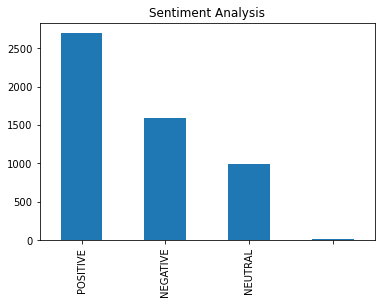

In [46]:
df.Sentiment_Type.value_counts().plot(kind='bar',title="Sentiment Analysis")